In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set_style('darkgrid')

### Data Loading and Initial Inspection

In [58]:
df = pd.read_csv('netflix_titles.csv')

In [59]:
df.tail()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7782,s7783,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...","Sweden, Czech Republic, United Kingdom, Denmar...","October 19, 2020",2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
7783,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...
7784,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast..."
7785,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...
7786,s7787,Movie,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS,Sam Dunn,NaN,"United Kingdom, Canada, United States","March 1, 2020",2019,TV-MA,90 min,"Documentaries, Music & Musicals",This documentary delves into the mystique behi...


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


**Interpretation of `.info()`:**
- We have 7787 entries (titles).
- **Key Problem:** The `date_added` column is of type `object` (a string), not a `datetime` object. We cannot perform time-based analysis until this is corrected.
- **Missing Values:** `director`, `cast`, `country`, `date_added`, and `rating` all have missing values. `director` has the most significant number of nulls.

In [61]:
df.describe()

,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


In [62]:
df.isnull().sum().to_frame()

,0
show_id,0
type,0
title,0
director,2389
cast,718
country,507
date_added,10
release_year,0
rating,7
duration,0


### Data Cleaning and Transformation

For null values, we have several strategies:
1.  **Drop:** If only a very small percentage of rows have missing data, dropping them might be acceptable (`.dropna()`).
2.  **Fill/Impute:** Replace missing values with a placeholder (like "Unknown") or a statistical measure (like the mode for categorical data). This is useful when you don't want to lose the other information in those rows.

In [63]:
# 1. Handling missing values of 'director' and 'cast'
# Since these are test fields and many are missing, we'll fill them with 'Unknown'

df.fillna({'director': 'Unknown', 'cast': 'Unknown'}, inplace=True)

In [64]:
df[['director', 'cast']].isnull().sum().to_frame(name='NA_Count')

,NA_Count
director,0
cast,0


In [65]:
# 2. Handle missing 'Country'

counts = df['country'].value_counts()
relative_frequency = df['country'].value_counts(normalize=True).mul(100).round(1)
pd.concat([counts, relative_frequency], axis=1, keys=['count', 'relative_frequency'])

,count,relative_frequency
country,,
United States,2555,35.1
India,923,12.7
United Kingdom,397,5.5
Japan,226,3.1
South Korea,183,2.5
...,...,...
"Russia, United States, China",1,0.0
"Italy, Switzerland, France, Germany",1,0.0
"United States, United Kingdom, Canada",1,0.0


We'll fill with the mode, which is the most common country.
- But why US why not India, the reason is when i say the count of all the countries, 
- USA is so high compare to all other that even the second highest can't reach till US if all the missing values are imputed with it.

In [66]:
df['country'] = df['country'].fillna(df['country'].mode()[0])

In [67]:
# 3. Looking forward for 'rating' and 'date_added'
# As the missing data is very low lets find the percentage of missing data from whole data for both column

missing_cnt = df[['date_added', 'rating']].isnull().sum()
percentage = df[['date_added', 'rating']].isnull().sum().div(df.shape[0]).mul(100)

pd.concat([missing_cnt, percentage], axis=1, keys=['missing_count', 'percentage_from_total_rows_in_data'])

,missing_count,percentage_from_total_rows_in_data
date_added,10,0.128419
rating,7,0.089893


- Drop the few rows with missing 'date_added' and 'rating'
- Since the number is small (less then 0.2% of data), dropping them is a safe option

In [68]:
df.dropna(subset=['date_added', 'rating'], inplace=True)

In [69]:
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [70]:
# 4. Convert 'date_added' to datetime objects
# Use format='mixed' to handle potential variations in data formats

df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', dayfirst=False)

In [71]:
df['date_added']

0      2020-08-14
1      2016-12-23
2      2018-12-20
3      2017-11-16
4      2020-01-01
          ...    
7782   2020-10-19
7783   2019-03-02
7784   2020-09-25
7785   2020-10-31
7786   2020-03-01
Name: date_added, Length: 7770, dtype: datetime64[ns]

In [72]:
# 5. Create new features for year and month added
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

In [73]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,11
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1


### EDA & Visualization

##### 1. What is the distribution of content type? (TV-Series, Movies)

In [74]:
value_counts = df['type'].value_counts()
value_counts

type
Movie      5372
TV Show    2398
Name: count, dtype: int64

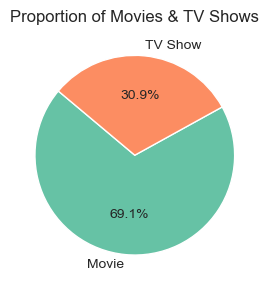

In [75]:
plt.figure(figsize=(14, 3))
plt.pie(value_counts,
        labels=value_counts.index, 
        startangle=140,
        autopct='%1.1f%%',
        colors=sns.color_palette('Set2'))
plt.title('Proportion of Movies & TV Shows')

plt.tight_layout()
plt.show()

##### 2. How has content been added over time?

In [76]:
content_over_years = df.groupby(['year_added', 'type']).size().unstack().fillna(0)
content_over_years

type,Movie,TV Show
year_added,,
2008,1.0,1.0
2009,2.0,0.0
2010,1.0,0.0
2011,13.0,0.0
2012,3.0,0.0
2013,6.0,5.0
2014,19.0,6.0
2015,58.0,30.0
2016,256.0,184.0


<Figure size 1400x600 with 0 Axes>

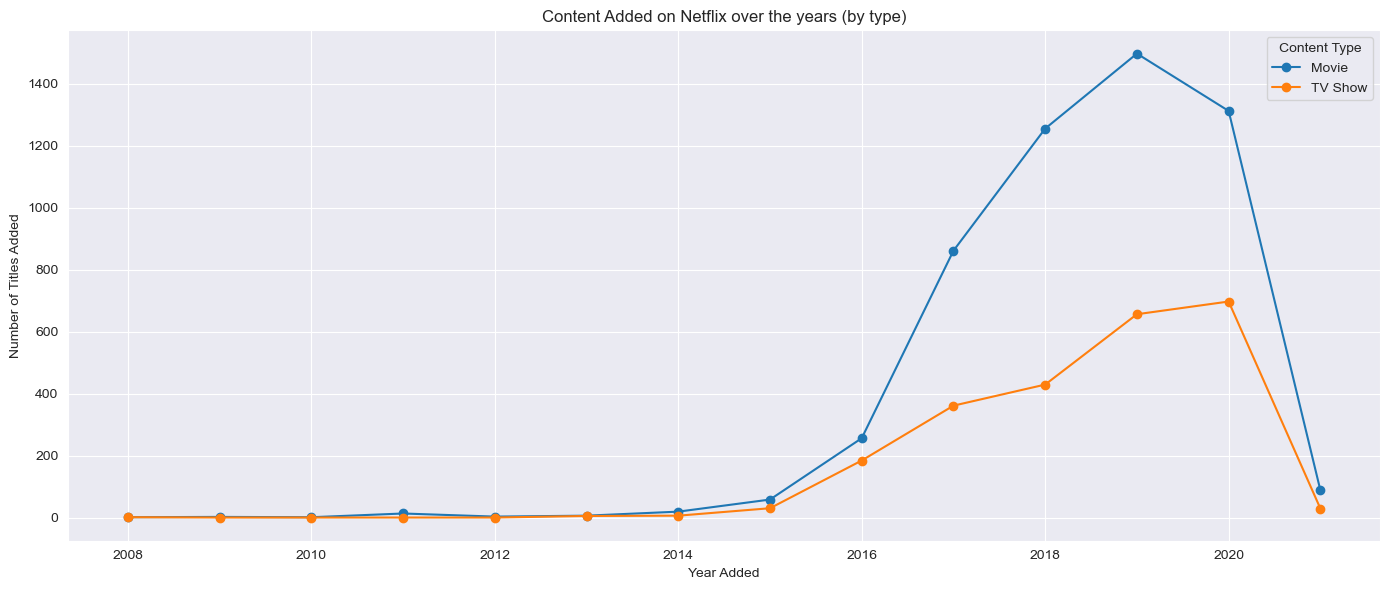

In [77]:
plt.figure(figsize=(14, 6))
content_over_years.plot(kind='line',
                       marker='o',
                       figsize=(14, 6))
plt.xlabel('Year Added')
plt.ylabel('Number of Titles Added')
plt.title('Content Added on Netflix over the years (by type)')
plt.legend(title='Content Type')

plt.grid(True)
plt.tight_layout()
plt.show()

**Insight:** By separating movies and TV shows, we can see that while both grew significantly, the addition of movies accelerated much more dramatically, peaking in 2019. The growth in TV shows has been more steady. There appears to be a slight slowdown in content additions in 2020 and 2021, which could be due to the COVID-19 pandemic affecting productions or the dataset being incomplete for the latest year.

##### 3. What are the most popular genres?

In [78]:
# genre = {}

# def fetch_genres(genres):
#     for i in genres:
#         genre[i] = genre.setdefault(i, 0) + 1

# df['listed_in'].str.split(', ').map(fetch_genres)

# genres_count = pd.DataFrame(genre.items(), columns=['Genre', 'Counts'])
# genres_count

In [79]:
genres = df.assign(genre=df['listed_in'].str.split(', ')).explode('genre')

In [80]:
top_genres_counts = genres['genre'].value_counts().reset_index()
top_genres_counts.columns = ['Genre', 'Counts']
top_15_genres = top_genres_counts.head(15)

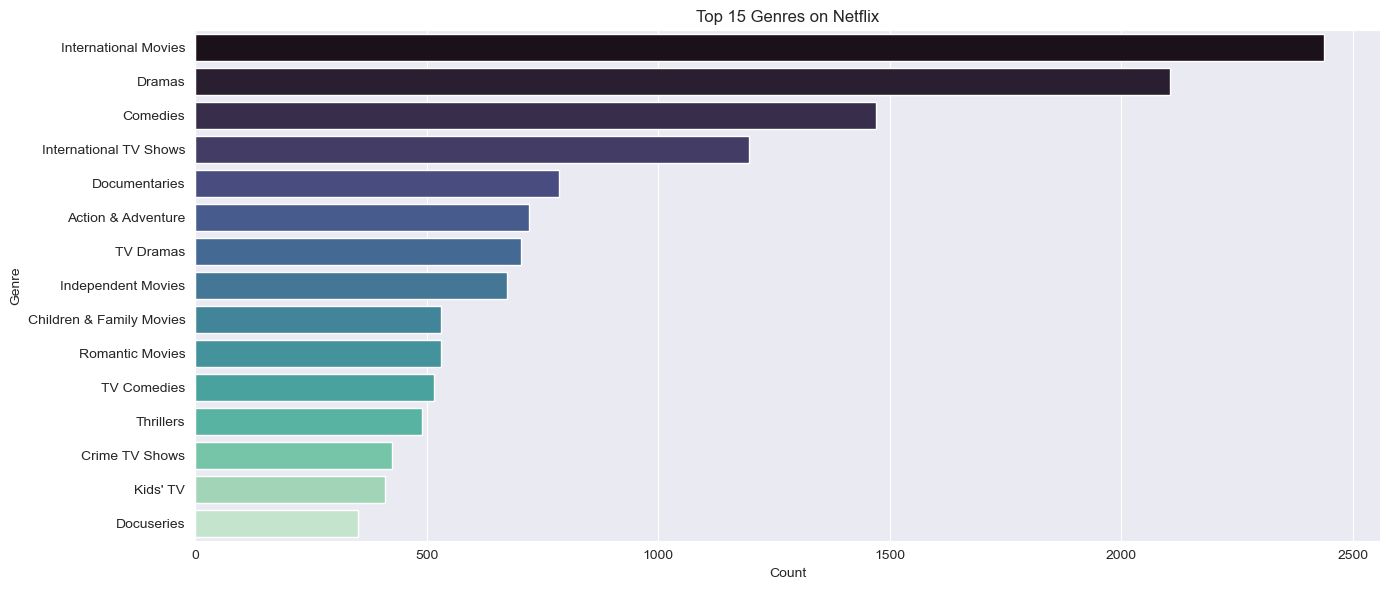

In [81]:
plt.figure(figsize=(14, 6))

sns.barplot(data=top_15_genres, x='Counts', y='Genre', hue='Genre', palette='mako')
plt.title('Top 15 Genres on Netflix')
plt.xlabel('Count')
plt.ylabel('Genre')

plt.tight_layout()
plt.show()

##### 4. What is the distribution of content duration?

In [82]:
df['duration'].value_counts()

duration
1 Season     1606
2 Seasons     378
3 Seasons     183
90 min        136
93 min        131
             ... 
182 min         1
224 min         1
37 min          1
233 min         1
191 min         1
Name: count, Length: 216, dtype: int64

In [83]:
df['type'].value_counts()

type
Movie      5372
TV Show    2398
Name: count, dtype: int64

In [84]:
movies_df = df[df['type'] == 'Movie'].copy()
tv_shows_df = df[df['type'] == 'TV Show'].copy()

In [85]:
movies_df['duration_min'] = movies_df['duration'].str.replace(' min', '').astype(int)

In [86]:
tv_shows_df['seasons'] = tv_shows_df['duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(int)

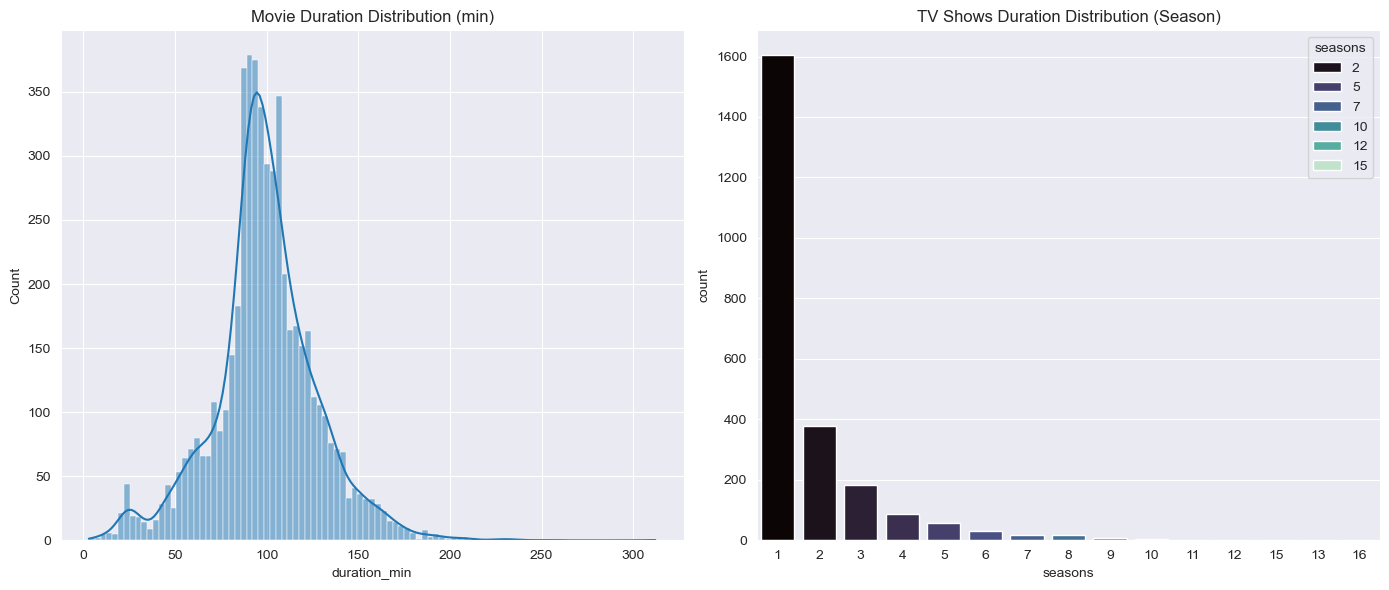

In [87]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=movies_df, 
             x='duration_min', 
             kde=True, 
             ax=axes[0]).set_title('Movie Duration Distribution (min)')
sns.countplot(data=tv_shows_df, 
              x='seasons', 
              hue='seasons', 
              order=tv_shows_df['seasons'].value_counts().index, 
              palette='mako',
              ax=axes[1]).set_title('TV Shows Duration Distribution (Season)')

plt.tight_layout()
plt.show()

**Insight:**
- The majority of movies on Netflix are between 80 and 120 minutes long, which is standard for feature films.
- The vast majority of TV shows on Netflix are short-lived, with most having only 1 season. This could reflect a strategy of producing many pilots and only renewing the most successful ones, or a focus on limited series.

##### 5. Where does the content come from? (Geographical Analysis)

In [88]:
df['country']

0                                                  Brazil
1                                                  Mexico
2                                               Singapore
3                                           United States
4                                           United States
                              ...                        
7782    Sweden, Czech Republic, United Kingdom, Denmar...
7783                                                India
7784                                        United States
7785                                            Australia
7786                United Kingdom, Canada, United States
Name: country, Length: 7770, dtype: object

In [89]:
# Handle the multi-country lisitings similar to genres
countries = df.assign(country=df['country'].str.split(', ')).explode('country')
top_countries_counts = countries['country'].value_counts().reset_index()
top_countries_counts.columns = ['Country', 'Counts']

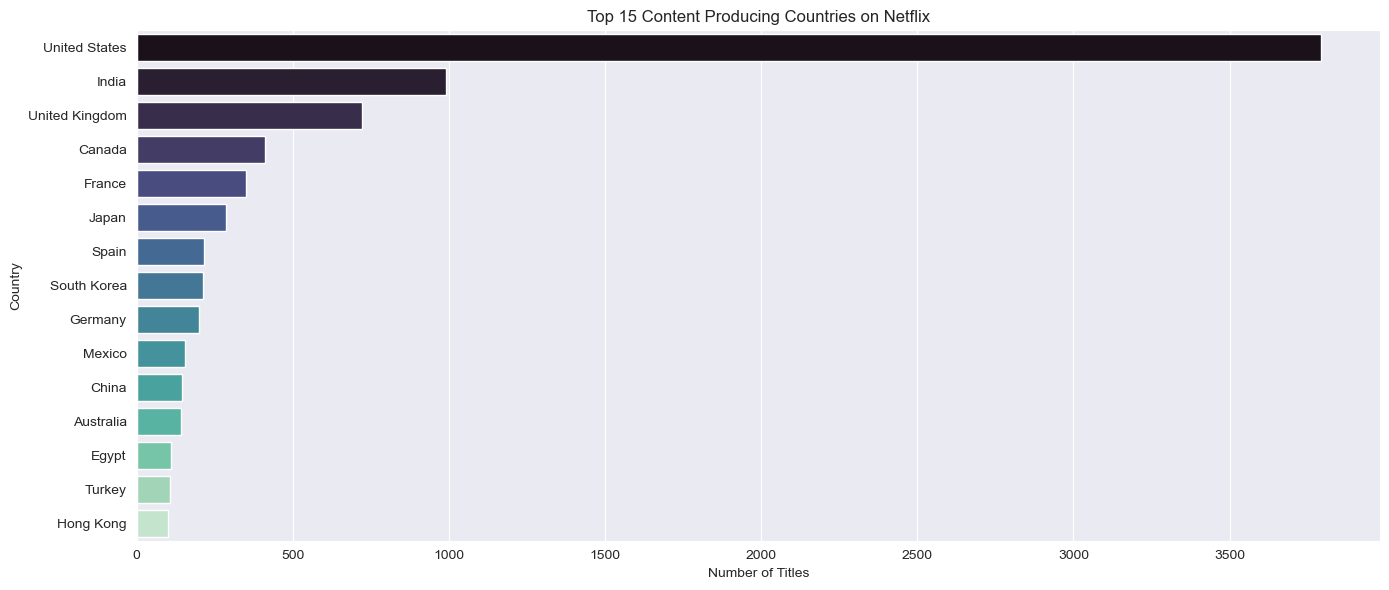

In [90]:
# Visual
top_15_countries_count = top_countries_counts.head(15)
plt.figure(figsize=(14, 6))

sns.barplot(data=top_15_countries_count, x='Counts', y='Country', hue='Country', palette='mako')
plt.title('Top 15 Content Producing Countries on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Country')

plt.tight_layout()
plt.show()

**Insight:** The United States is by far the largest producer of content available on Netflix. However, India is a very strong second, which explains why so many of the top actors were from India. The UK, Japan, and South Korea also represent major content markets for the platform, emphasizing its global nature.

##### 6. What are the maturity ratings of the content?

In [91]:
df['rating'].value_counts()

rating
TV-MA       2861
TV-14       1928
TV-PG        804
R            665
PG-13        386
TV-Y         279
TV-Y7        270
PG           247
TV-G         194
NR            83
G             39
TV-Y7-FV       6
UR             5
NC-17          3
Name: count, dtype: int64

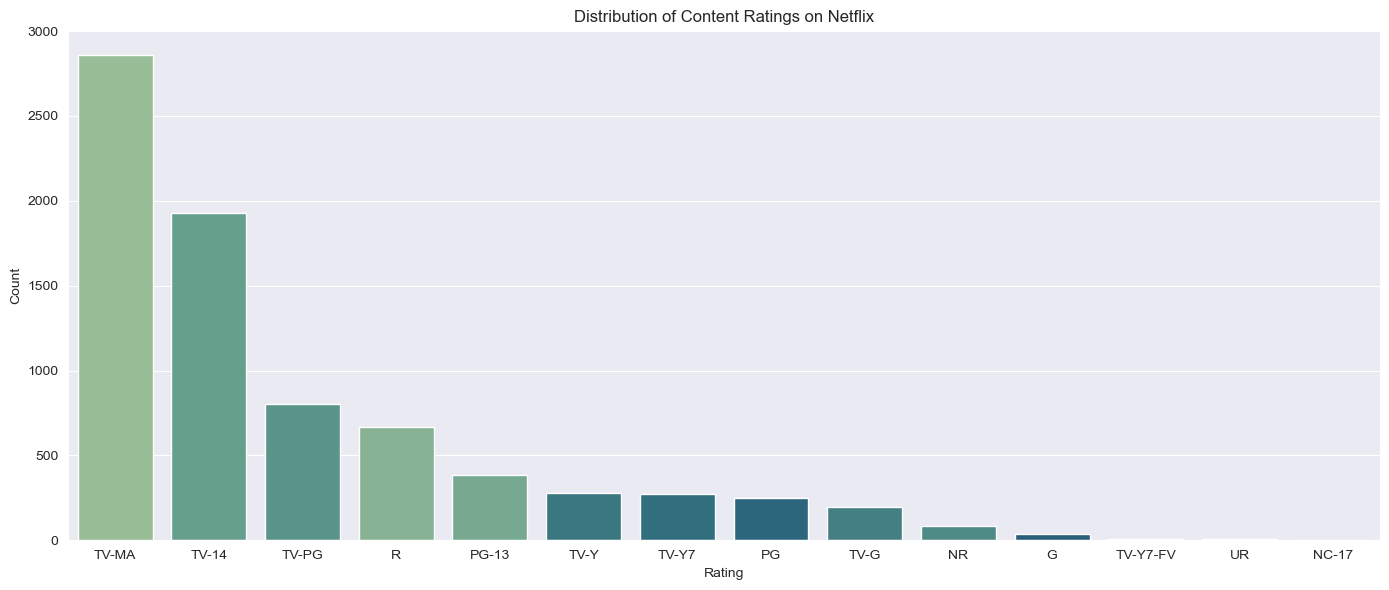

In [92]:
fig, axes = plt.subplots(figsize=(14, 6))

sns.countplot(data=df, x='rating', order=df['rating'].value_counts().index, hue='rating', palette='crest')
plt.title('Distribution of Content Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Insight:** A large portion of Netflix's content is aimed at mature audiences, with `TV-MA` (Mature Audience) and `TV-14` (Parents Strongly Cautioned) being the two most common ratings. This suggests a focus on adult viewers over content for children (`TV-G`, `TV-Y`).

### Feature Engineering

Let's create a new feature to analyze how old content is when it gets added to Netflix. This can tell us about their acquisition strategy (buying old classics vs. releasing new originals).

In [93]:
# Create the 'age_on_netflix' feature
df['age_on_netflix'] = df['year_added'] - df['release_year']

In [94]:
# Edge case if possible avoid that
content_age = df[df['age_on_netflix'] >= 0]

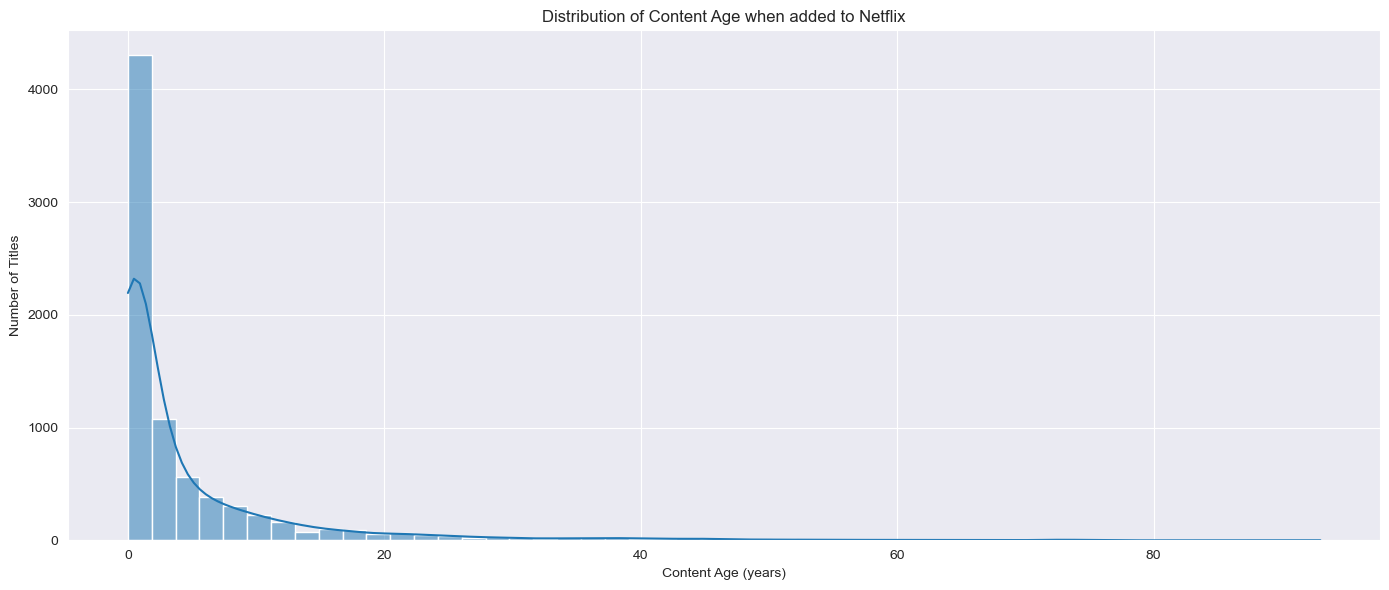

In [95]:
# Visual
plt.figure(figsize=(14, 6))
sns.histplot(data=content_age, x='age_on_netflix', bins=50, kde=True)
plt.title('Distribution of Content Age when added to Netflix')
plt.xlabel('Content Age (years)')
plt.ylabel('Number of Titles')

plt.tight_layout()
plt.show()

**Insight:** The large spike at `0` indicates that a significant amount of content is added in the same year it's released, which is characteristic of "Netflix Originals." However, there is a very long tail, showing that Netflix also heavily invests in acquiring licensed content that can be decades old, building a deep library of classic films and shows.

### Deeper Multivariate Analysis

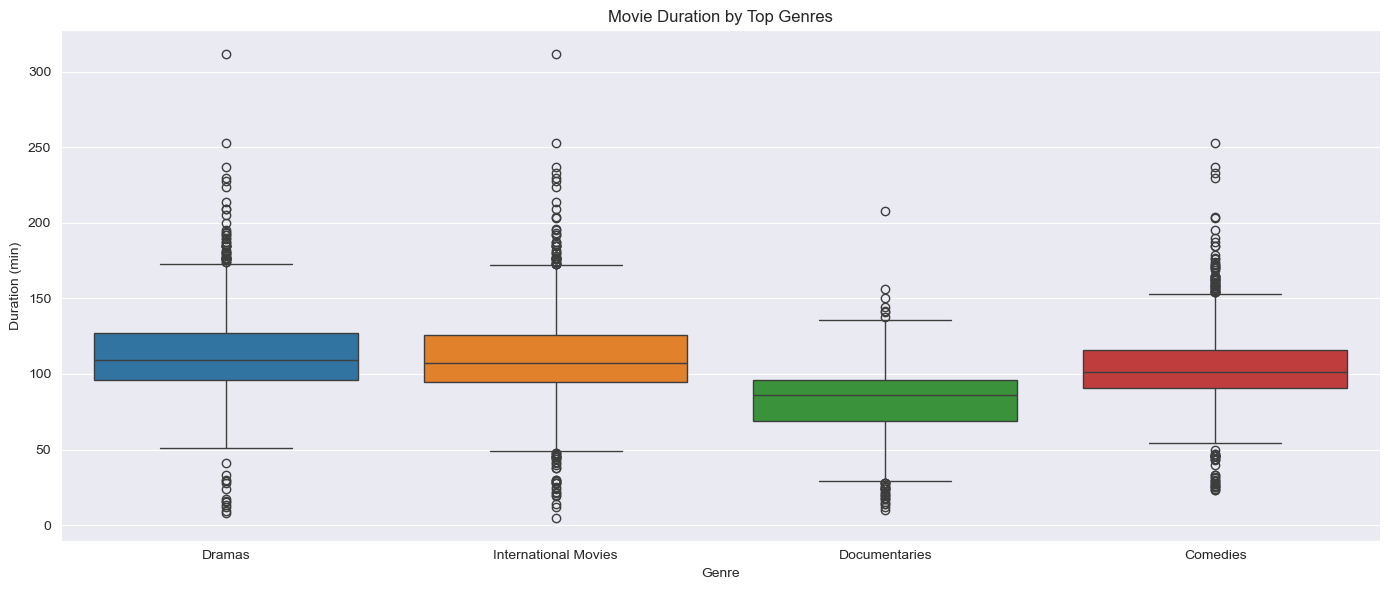

In [96]:
# Analyze movie duration across different top genres
top_genres = genres['genre'].value_counts().index[:5]
genres_movies = genres[(genres['type'] == 'Movie') & (genres['genre'].isin(top_genres))].copy()
genres_movies['duration_min'] = genres_movies['duration'].str.replace(' min', '').astype(int)

plt.figure(figsize=(14, 6))

sns.boxplot(data=genres_movies, x='genre', y='duration_min', hue='genre')
plt.title('Movie Duration by Top Genres')
plt.xlabel('Genre')
plt.ylabel('Duration (min)')

plt.tight_layout()
plt.show()

**Insight:** While the median duration for most top genres is similar (around 90-100 minutes), we can see some interesting variations. For example, Dramas tend to have a wider range of durations, with many longer films. International Movies also show a broad distribution, reflecting diverse filmmaking styles from around the world.

### Word Cloud from Content Descriptions

As a final visual analysis, let's generate a word cloud from the `description` column to see what themes and words are most common in Netflix content.

In [97]:
df['description']

0       In a future where the elite inhabit an island ...
1       After a devastating earthquake hits Mexico Cit...
2       When an army recruit is found dead, his fellow...
3       In a postapocalyptic world, rag-doll robots hi...
4       A brilliant group of students become card-coun...
                              ...                        
7782    When Lebanon's Civil War deprives Zozo of his ...
7783    A scrappy but poor boy worms his way into a ty...
7784    In this documentary, South African rapper Nast...
7785    Dessert wizard Adriano Zumbo looks for the nex...
7786    This documentary delves into the mystique behi...
Name: description, Length: 7770, dtype: object

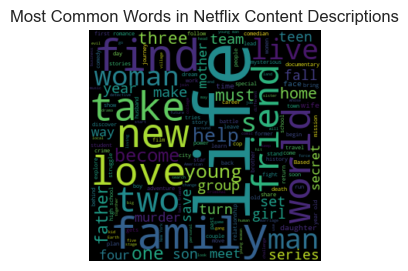

In [98]:
text = ' '.join(df['description'])

wordcloud = WordCloud(width=300, height=300, background_color='black').generate(text)

plt.figure(figsize=(6, 3))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Content Descriptions')

# plt.tight_layout()
plt.show()

**Insight:** The word cloud highlights common themes and subjects. Words like "life," "family," "love," "young," "friends," and "world" are prominent, suggesting that much of the content revolves around human relationships and personal journeys. Action-oriented words like "find," "secret," and "new" also appear frequently.

### Conclusion

This in-depth EDA of the Netflix dataset has revealed several key characteristics and strategies of the platform's content library.

**Key Findings:**
1. **Content Strategy:** Netflix's library is movie-heavy (~70%), and the platform aggressively added content between 2016-2019. Their strategy involves a mix of brand new originals (added the same year they are released) and a deep library of licensed older content.
2. **Global Dominance:** While the US is the top content producer, the platform is heavily international, with India being a massive contributor. This is reflected in the top genres ("International Movies") and most frequent actors.
3. **Target Audience:** The content library is skewed towards mature audiences, with `TV-MA` and `TV-14` being the most common ratings.
4. **Content Format & Genre:** Dramas and Comedies are universally popular genres. Most movies stick to a standard 90-120 minute runtime, while the vast majority of TV shows only last for a single season, suggesting a high-risk, high-reward approach to series production.
5. **Common Themes:** Descriptions of content frequently revolve around universal themes of life, family, love, and discovery.

**Limitations:** This dataset is a snapshot in time and lacks viewership data. Therefore, our analysis is of the *supply* of content, not its *demand* or popularity. Nonetheless, this EDA provides a strong, multi-faceted understanding of the composition and evolution of the Netflix library.

### Some Questions

1. How has the distribution of content ratings changed over time?
2. Is there a relationship between content age and its type (Movie vs. TV Show)?
3. Can we identify any trends in content production based on the release year vs. the year added to Netflix?
4. What are the most common word pairs or phrases in content descriptions?
5. Who are the top directors on Netflix?

<Figure size 1400x600 with 0 Axes>

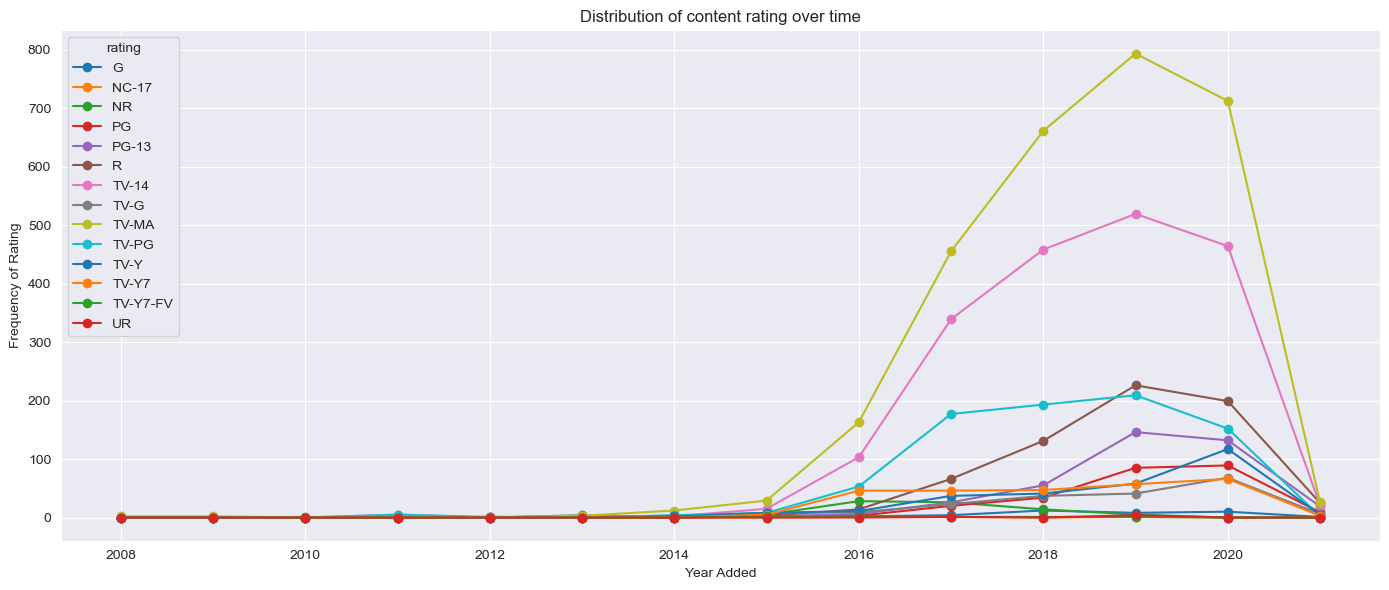

In [99]:
# 1. How has the distribution of content ratings changed over time?
rating_over_time = df.groupby(['year_added', 'rating']).size().unstack().fillna(0)

plt.figure(figsize=(14, 6))
rating_over_time.plot(kind='line',
                     marker='o',
                     figsize=(14, 6))
plt.xlabel('Year Added')
plt.ylabel('Frequency of Rating')
plt.title('Distribution of content rating over time')

plt.tight_layout()
plt.show()

**Insight:** The distribution of content ratings shows a strong rise after 2015, with TV-MA and TV-14 becoming the most dominant ratings. This indicates Netflix’s growing focus on mature and adult-oriented content over time, while kids and general-audience ratings remain comparatively low.

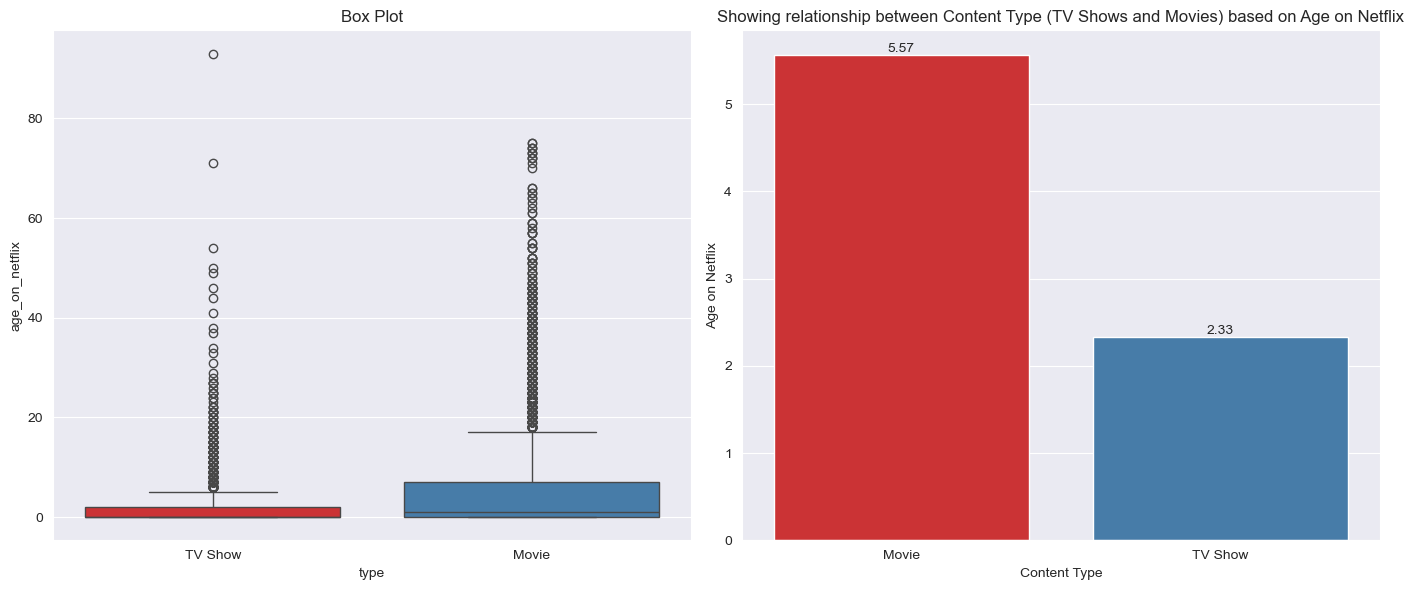

In [101]:
# 2. Is there a relationship between content age and its type (Movie vs. TV Show)?
age_on_netflix = df[df['age_on_netflix'] >= 0]
type_mean = age_on_netflix.groupby('type')['age_on_netflix'].mean().reset_index()

fix, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(data=age_on_netflix,
           x='type', y='age_on_netflix',
           hue='type', palette='Set1',
           ax=axes[0]).set_title('Box Plot')

sns.barplot(data=type_mean,
             y='age_on_netflix', x='type',
             hue='type', palette='Set1',
             ax=axes[1]).set_title('Mean Relationship')

# Add value labels on each bar
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

plt.xlabel('Content Type')
plt.ylabel('Age on Netflix')
plt.title('Showing relationship between Content Type (TV Shows and Movies) based on Age on Netflix')

plt.tight_layout()
plt.show()

**Insight:** The plots show a clear relationship between content age and type. Movies have a higher average age on Netflix than TV Shows, indicating that movies tend to stay on the platform longer or are added later after release. TV shows, on the other hand, are generally newer and added more recently, reflecting Netflix’s focus on fresh series content.

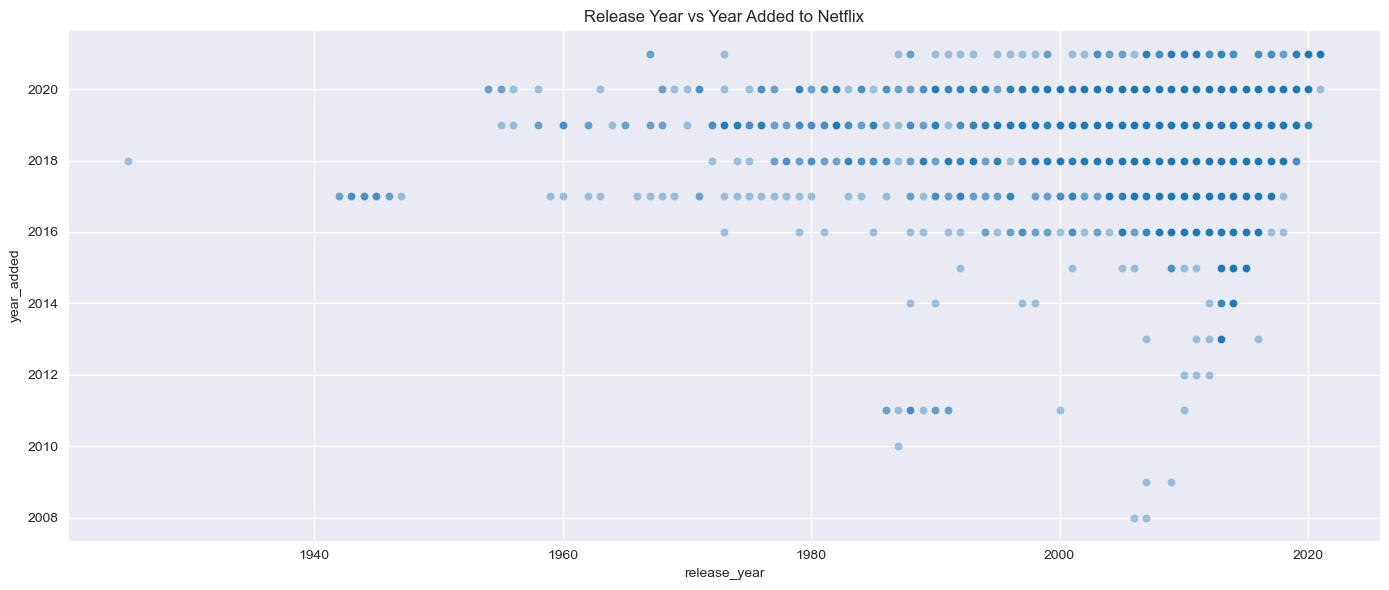

In [102]:
# 3. Can we identify any trends in content production based on the release year vs. the year added to Netflix?
plt.figure(figsize=(14, 6))

sns.scatterplot(data=df,
               x='release_year', y='year_added',
               alpha=0.4)

plt.title('Release Year vs Year Added to Netflix')

plt.tight_layout()
plt.show()

**Insight:** The scatter plot shows that older content generally has a larger gap between its release year and the year it was added to Netflix. In contrast, recently released content is added much faster, often within the same or nearby years. This trend indicates that Netflix has shifted toward acquiring and releasing newer content more quickly over time.

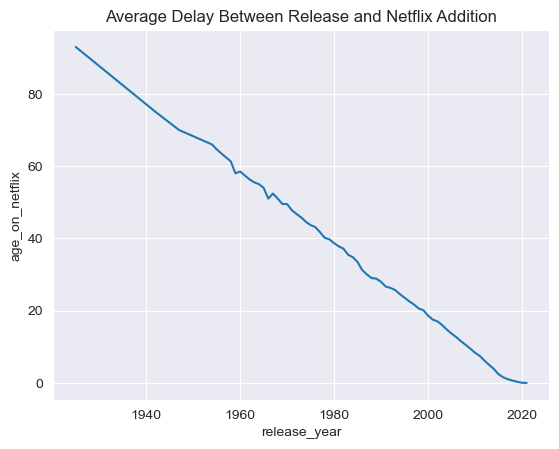

In [103]:
delay_trend = df.groupby('release_year')['age_on_netflix'].mean().reset_index()

sns.lineplot(
    data=delay_trend,
    x='release_year',
    y='age_on_netflix'
)
plt.title('Average Delay Between Release and Netflix Addition')
plt.show()

**Insight:** The line plot shows a steady decline in the average delay between a title’s release year and its addition to Netflix. Older content experienced long delays before being added, while recent releases are added almost immediately. This trend highlights Netflix’s increasing focus on timely acquisition and newer content.

In [104]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,age_on_netflix
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12,7
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,11,8
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1,12


In [111]:
# 4. What are the most common word pairs or phrases in content descriptions?
from sklearn.feature_extraction.text import CountVectorizer

# Func to extract most common word pairs
def word_pairs(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    bow = vec.fit_transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_25_common_phrases = word_pairs(df['description'], 25)
top_25_common_phrases_df = pd.DataFrame(top_25_common_phrases, columns=['phrase', 'count'])

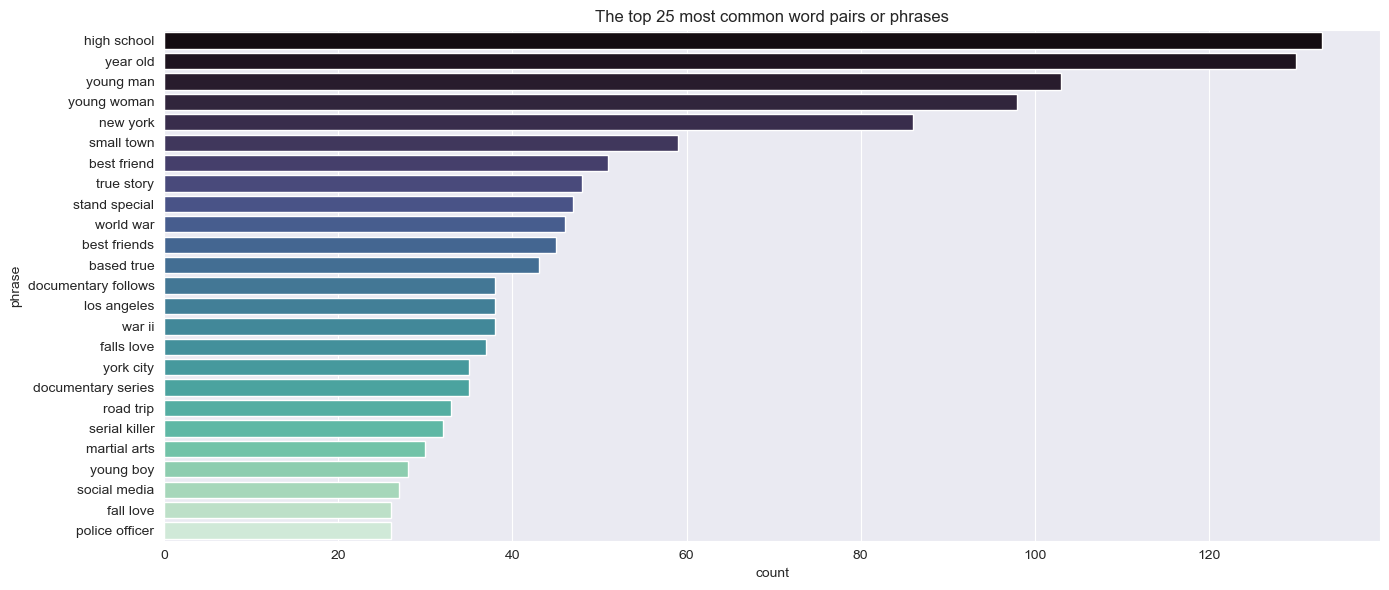

In [114]:
plt.figure(figsize=(14, 6))

sns.barplot(data=top_25_common_phrases_df,
           x='count', y='phrase',
           hue='phrase', palette='mako')
plt.title('The top 25 most common word pairs or phrases')

plt.tight_layout()
plt.show()

**Inference:** The bar chart shows that the most common word pairs in Netflix content descriptions include phrases like “high school,” “young man,” “young woman,” and “small town.” These frequently occurring phrases highlight dominant themes such as youth, relationships, personal journeys, crime, and documentaries. Overall, the pattern suggests that Netflix content descriptions often focus on coming-of-age stories, human relationships, and real-world narratives, reflecting popular storytelling trends on the platform.

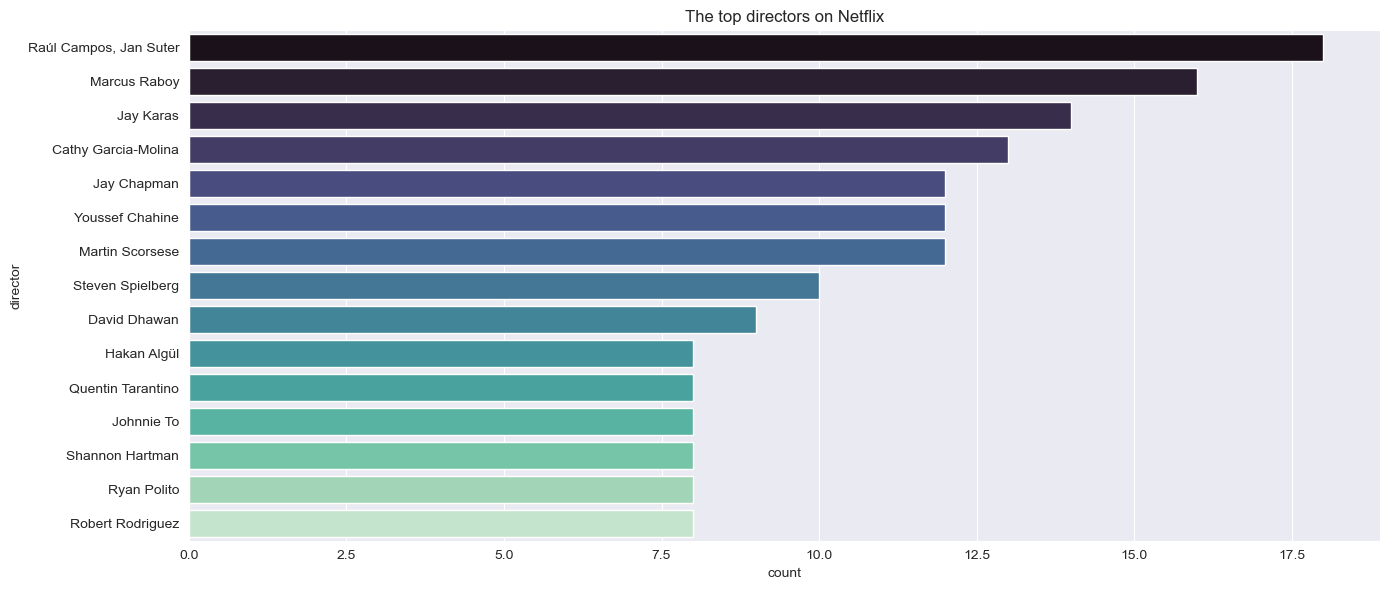

In [127]:
# 5. Who are the top directors on Netflix?
top_15_directors = df[df['director'] != 'Unknown']['director'].value_counts().reset_index().head(15)

plt.figure(figsize=(14, 6))

sns.barplot(data=top_15_directors,
           x='count', y='director',
           hue='director', palette='mako')
plt.title('The top directors on Netflix')

plt.tight_layout()
plt.show()

**Inference:** The bar chart highlights a small group of directors who contribute the most content to Netflix. Raúl Campos and Jan Suter lead the list, followed by directors like Marcus Raboy and Jay Karas, indicating repeated collaborations with the platform. Overall, this suggests that Netflix frequently works with a core set of directors, especially for stand-up specials and recurring content formats.